<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode006.cluster


In [2]:
!nvidia-smi

Mon May  8 13:55:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:17:00.0 Off |                    0 |
| N/A   27C    P0    37W / 250W |  10916MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

1.13.0+cu117
11.7


200.0
(1500, 400) (1500, 400)
(400, 400) (400, 400) (400, 400)
(400, 400, 2)
CPU times: user 2.43 s, sys: 23.1 ms, total: 2.45 s
Wall time: 2.52 s


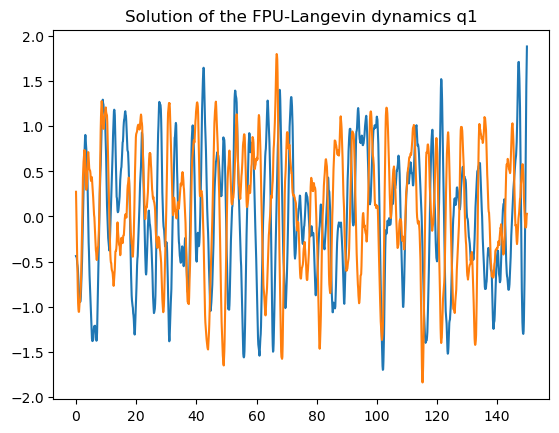

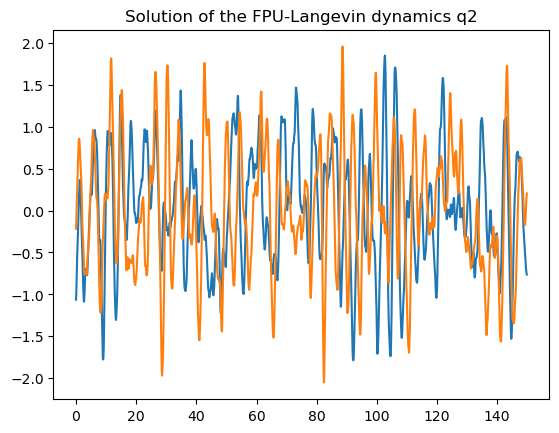

In [7]:
%%time

#### Generating SINN training data by solving SDE (Langevin dynamics)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


def V_FPU(x,U0,x0):
    v=U0/x0**4*x**3+U0/x0**2*x      # FPU potential 
    return v


#### Parameters 
gamma = 1                              # coupling constant 
beta = 1                               # Inverse temperature, i.e. T=1/beta
dt = 0.01                              # Step-size of the SDE solver 
delta_t = 0.1                          # Step-size of the temporally coarse-grained path
batch = 400                            # Batch size 
sec_length = 400                       # Length of the input sequence 
U0 = 1                                 # FPU parameter, depth of the well 
x0 = 1                                 # FPU parameter, position of the basin 
alpha = 0.00                           # Correlation of q1 and q2 

#### SDE solver (EM scheme) 
Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
q1_store = np.zeros([t_store.size+1,batch])
q2_store = np.zeros([t_store.size+1,batch])
# q_store = np.zeros([t_store.size+1,batch])
p1=np.zeros((2,batch))
p2=np.zeros((2,batch))
q1=np.zeros((2,batch))
q2=np.zeros((2,batch))

# solve SDE
j=1
for i in range(1,length):
     q1[1,:] = q1[0,:] + p1[0,:]*dt
     p1[1,:] = p1[0,:] + (-V_FPU(q1[0,:],U0,x0)-gamma*p1[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma/beta)
     q2[1,:] = q2[0,:] + p2[0,:]*dt
     p2[1,:] = p2[0,:] + (-V_FPU(q2[0,:],U0,x0)-gamma*p2[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma/beta)
     if i % gap ==0:            
            q1_store[j,:]=q1[1,:]
            q2_store[j,:]=np.sqrt(alpha)*q1[1,:]+np.sqrt(1-alpha)*q2[1,:]
            j=j+1
     p1[0,:]=p1[1,:]
     q1[0,:]=q1[1,:]
     p2[0,:]=p2[1,:]
     q2[0,:]=q2[1,:]

Toss=int(t_store.size/4)         
q1_store=q1_store[Toss:-1,:]         
q2_store=q2_store[Toss:-1,:]    
print(q1_store.shape,q2_store.shape)



plt.figure(0)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,i])
plt.title("Solution of the FPU-Langevin dynamics q1")
# plt.savefig("figs/FPU_dt016.pdf", dpi=150)

plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,i])
plt.title("Solution of the FPU-Langevin dynamics q2")

# Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj_q1=q1_store[0:sec_length,:]
Traj_q2=q2_store[0:sec_length,:]
print(ini.shape, Traj_q1.shape, Traj_q2.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj_q1
Traj[:,:,1] = Traj_q2
T=np.arange(len(Traj_q1[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(Traj.shape)

In [8]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [9]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, device=device)

torch.Size([400, 2])


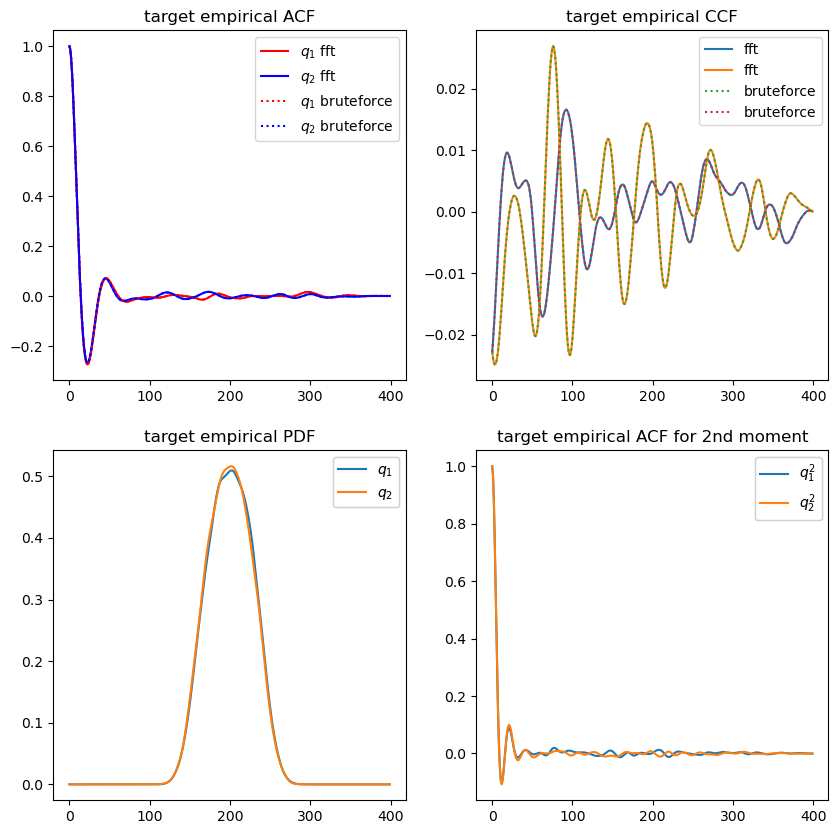

In [10]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_1$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,-1],'b', label=r'$q_2$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_1$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_2$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_1$', '$q_2$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_1^2$', '$q_2^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

# 1. 1 input

In [11]:
def SINN_training(net, optimizer, c1, c2, c3):
    # Training SINN
    T_error=[]
    V_error=[]
    T_ccf=[]
    V_ccf=[]
    T_pdf=[]
    V_pdf=[]
    T_acf=[]
    V_acf=[]
    Step=[]
    for step in range(20000):
        optimizer.zero_grad()
        ini = np.random.randn(2*sec_length, batch).astype(np.float32) 
        input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
        prediction, _ = net(input)
        prediction = prediction[-LAGS:,:,:]
        loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
        loss.backward()
        optimizer.step()
        if step % 50 == 0: 
            with torch.no_grad():
                pred_val, _ = net(val_set)
                pred_val = pred_val[-LAGS:,:,:]
                loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
                print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
                T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
                V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
                T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                T_error.append(loss.detach().cpu().numpy())
                V_error.append(loss_val.detach().cpu().numpy())
                Step.append(step)
        if loss<=0.002 and loss_val<=0.0025:
                break
    print('Training finished')
    return Step, T_error, V_error, T_ccf, V_ccf, T_pdf, V_pdf, T_acf, V_acf

In [12]:
import time
def exec_time(start, end):
   diff_time = end - start
   m, s = divmod(diff_time, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))
   return "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)

In [13]:
### coefficients of loss functions
c1 = 20               # coefficient of CCF
c2 = 1              # coefficient of PDF
c3 = 10               # coefficient of ACF of second moment

In [14]:
### Defining SINN model
net5 = SINN(1, 5, 2, 2).to(device)
optimizer5 = optim.Adam(net5.parameters(), lr=1e-3)

In [15]:
%%time
start = time.time()
Step5, T_error5, V_error5, T_ccf5, V_ccf5, T_pdf5, V_pdf5, T_acf5, V_acf5 = SINN_training(net5, optimizer5, c1, c2, c3)
end = time.time()

[0]-th step loss: 0.419, 0.412
[50]-th step loss: 0.367, 0.368
[100]-th step loss: 0.334, 0.332
[150]-th step loss: 0.291, 0.290
[200]-th step loss: 0.226, 0.224
[250]-th step loss: 0.185, 0.185
[300]-th step loss: 0.173, 0.173
[350]-th step loss: 0.163, 0.163
[400]-th step loss: 0.141, 0.142
[450]-th step loss: 0.089, 0.088
[500]-th step loss: 0.057, 0.056
[550]-th step loss: 0.040, 0.038
[600]-th step loss: 0.027, 0.026
[650]-th step loss: 0.022, 0.021
[700]-th step loss: 0.017, 0.017
[750]-th step loss: 0.026, 0.024
[800]-th step loss: 0.013, 0.013
[850]-th step loss: 0.011, 0.011
[900]-th step loss: 0.010, 0.011
[950]-th step loss: 0.018, 0.017
[1000]-th step loss: 0.008, 0.007
[1050]-th step loss: 0.009, 0.010
[1100]-th step loss: 0.007, 0.008
[1150]-th step loss: 0.007, 0.008
[1200]-th step loss: 0.006, 0.007
[1250]-th step loss: 0.006, 0.007
[1300]-th step loss: 0.005, 0.006
[1350]-th step loss: 0.005, 0.006
[1400]-th step loss: 0.006, 0.006
[1450]-th step loss: 0.005, 0.006
[15

[12050]-th step loss: 0.164, 0.162
[12100]-th step loss: 0.162, 0.160
[12150]-th step loss: 0.181, 0.161
[12200]-th step loss: 0.162, 0.158
[12250]-th step loss: 0.162, 0.163
[12300]-th step loss: 0.162, 0.164
[12350]-th step loss: 0.162, 0.165
[12400]-th step loss: 0.164, 0.162
[12450]-th step loss: 0.170, 0.172
[12500]-th step loss: 0.169, 0.171
[12550]-th step loss: 0.168, 0.168
[12600]-th step loss: 0.166, 0.167
[12650]-th step loss: 0.170, 0.169
[12700]-th step loss: 0.169, 0.167
[12750]-th step loss: 0.180, 0.167
[12800]-th step loss: 0.169, 0.170
[12850]-th step loss: 0.167, 0.167
[12900]-th step loss: 0.166, 0.166
[12950]-th step loss: 0.165, 0.166
[13000]-th step loss: 0.166, 0.166
[13050]-th step loss: 0.167, 0.166
[13100]-th step loss: 0.165, 0.166
[13150]-th step loss: 0.165, 0.166
[13200]-th step loss: 0.165, 0.166
[13250]-th step loss: 0.166, 0.167
[13300]-th step loss: 0.164, 0.166
[13350]-th step loss: 0.165, 0.165
[13400]-th step loss: 0.165, 0.165
[13450]-th step loss

In [16]:
time5=exec_time(start,end)

Execution Time: 00:27:43


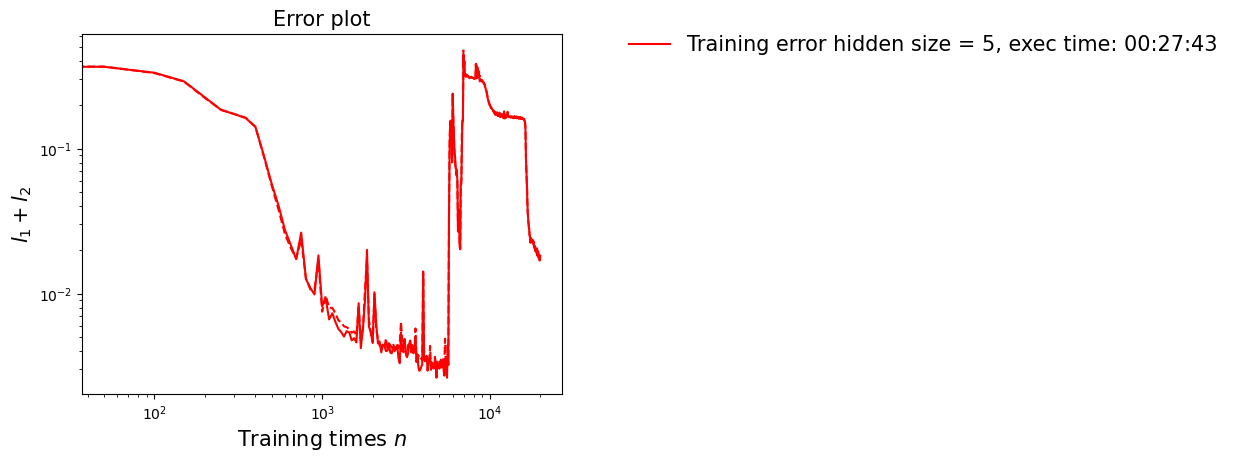

In [27]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step5, T_error5,'r',label='Training error hidden size = 5, exec time: %s'%time5)
plt.loglog(Step5, V_error5,'r--')
# plt.loglog(Step4, T_error4,'b',label='Training error hidden size = 4, exec time: %s'%time4)
# plt.loglog(Step4, V_error4,'b--')
# plt.loglog(Step3, T_error3,'g',label='Training error hidden size = 3, exec time: %s'%time3)
# plt.loglog(Step3, V_error3,'g--')
# plt.loglog(Step2, T_error2,'k',label='Training error hidden size = 2, exec time: %s'%time2)
# plt.loglog(Step2, V_error2,'k--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

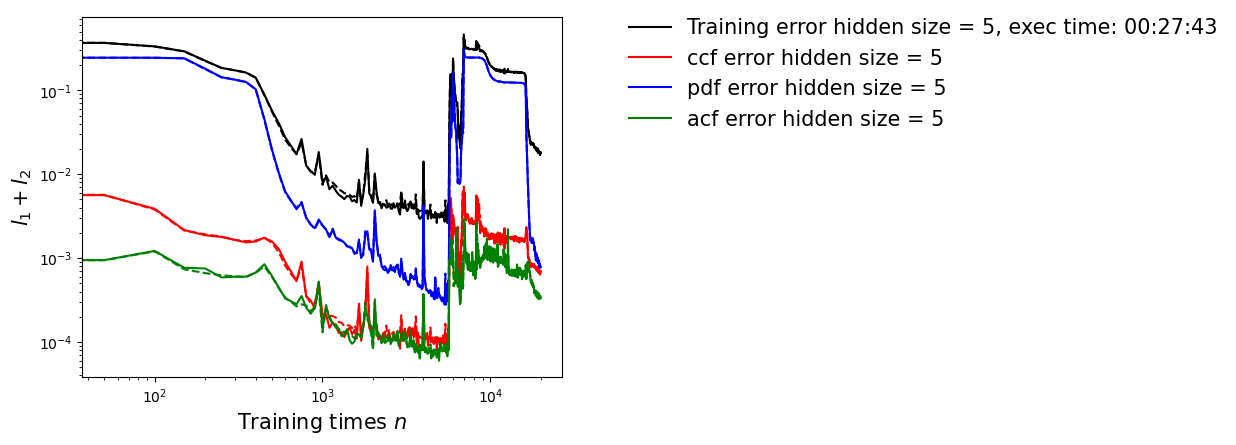

In [28]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.loglog(Step5, T_error5,'k',label='Training error hidden size = 5, exec time: %s'%time5)
plt.loglog(Step5, V_error5,'k--')
plt.loglog(Step5, T_ccf5,'r',label='ccf error hidden size = 5')
plt.loglog(Step5, V_ccf5,'r--')
plt.loglog(Step5, T_pdf5,'b',label='pdf error hidden size = 5')
plt.loglog(Step5, V_pdf5,'b--')
plt.loglog(Step5, T_acf5,'g',label='acf error hidden size = 5')
plt.loglog(Step5, V_acf5,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

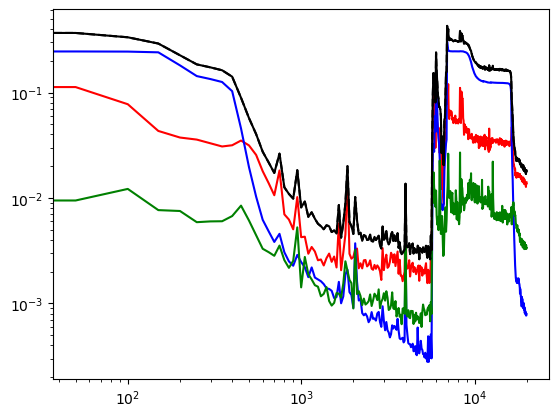

In [29]:
T_ccf5_new = [i * c1 for i in T_ccf5]
T_pdf5_new = [i * c2 for i in T_pdf5]
T_acf5_new = [i * c3 for i in T_acf5]
T_err5_new = [x + y + z for x, y, z in zip(T_ccf5_new, T_pdf5_new, T_acf5_new)]
plt.loglog(Step5, T_ccf5_new,'r',label='ccf error hidden size = 5')
plt.loglog(Step5, T_pdf5_new,'b',label='pdf error hidden size = 5')
plt.loglog(Step5, T_acf5_new,'g',label='acf error hidden size = 5')
plt.loglog(Step5, T_err5_new,'k--',label='sum error hidden size = 5')
plt.loglog(Step5, T_error5,'k',label='Training error hidden size = 5, exec time: %s'%time5)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [31]:
def test1(Traj, T, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$ and $q_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$ and $q_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

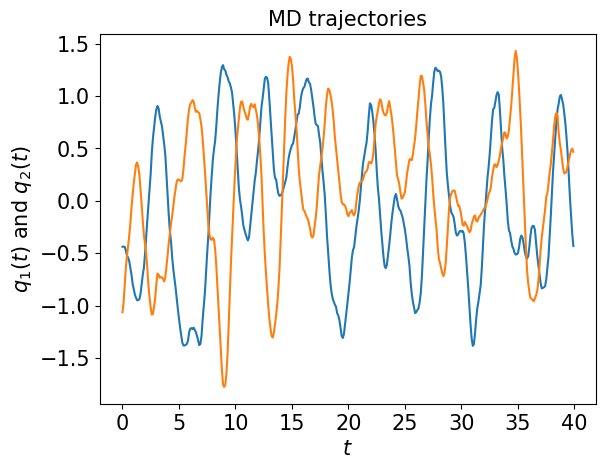

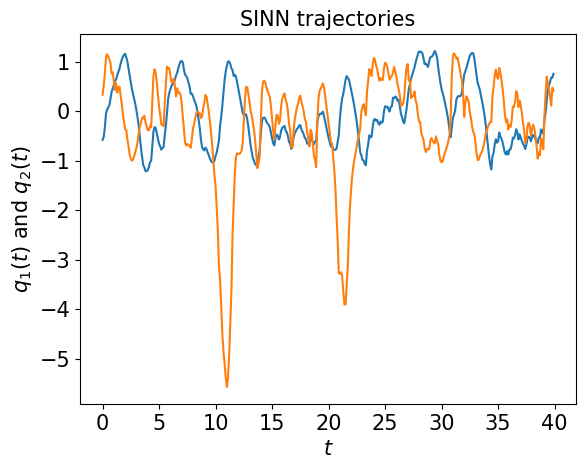

In [32]:
test1(Traj, T, net5)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [33]:
def test2(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p=ccf_p.detach().cpu().numpy()
    corr_t=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_1$',fontsize=15)    
    plt.plot(T, corr_t[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_2$',fontsize=15)          
    plt.plot(T, corr_t[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t[...,1:3],'r')        # correlation function of the target 
    plt.plot(T, corr_p[...,1:3], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])

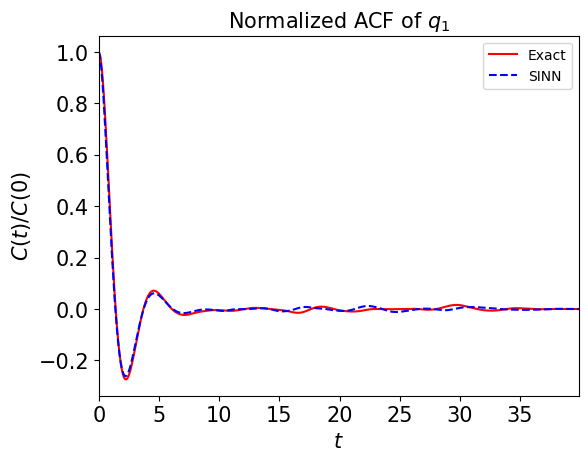

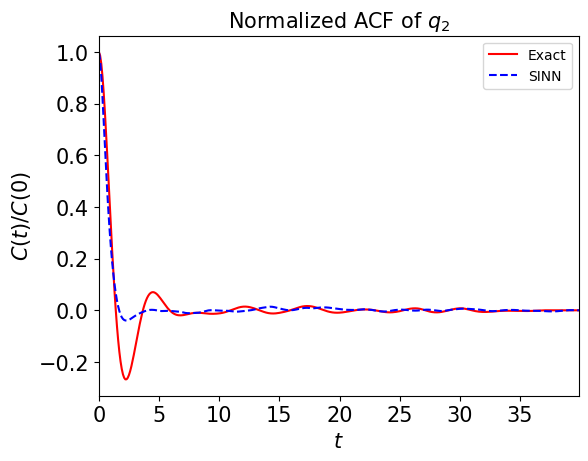

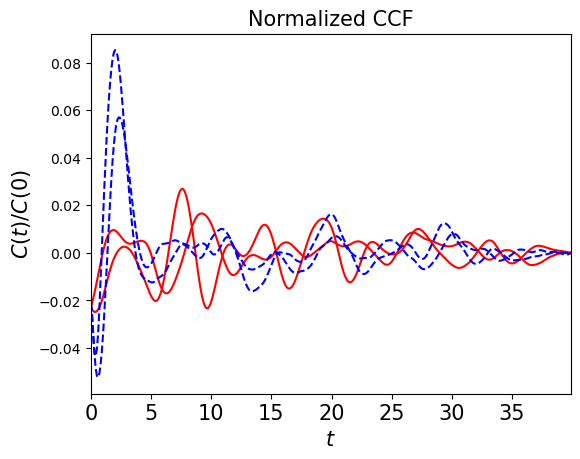

In [34]:
test2(target, net5)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [35]:
def test3(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


    x=np.linspace(-5, 5, 100)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_1$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_2$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_1$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

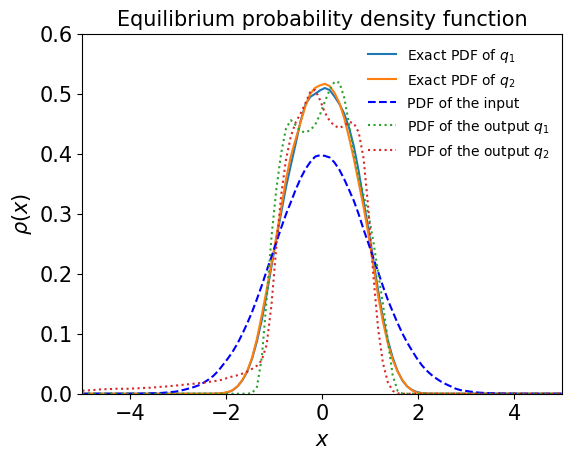

In [36]:
test3(target, net5)

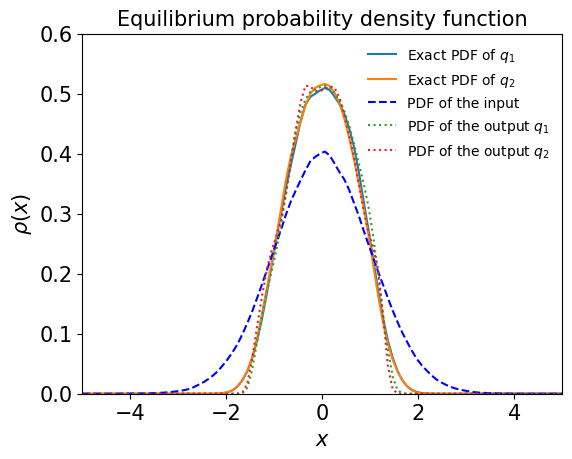

In [37]:
test3(target, net4)

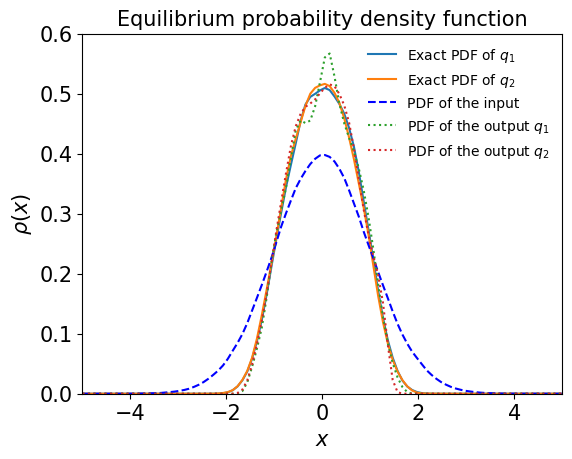

In [38]:
test3(target, net3)

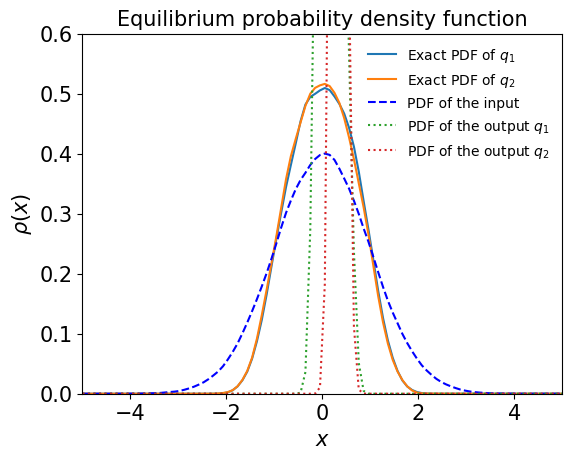

In [39]:
test3(target, net2)

## Test 4: Comparing the higher-order ACF

In [40]:
def test4(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],label=r'Exact correlation of $q_1^2(t)$')        # Exact correlation function 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], '--',label=r'Correlation of the output $q_1^2$')        # Correlation function after the training 
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],label=r'Exact correlation of $q_2^2(t)$')        # Exact correlation function 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], '--',label=r'Correlation of the output $q_2^2$')        # Correlation function after the training 
    plt.xlim(0,30)
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend(frameon=False,fontsize=15)

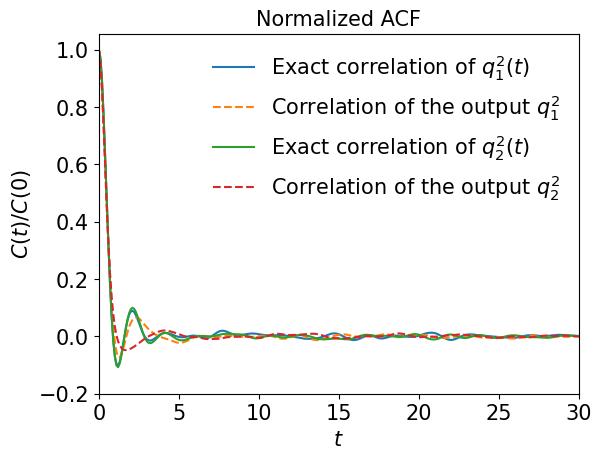

In [41]:
test4(target, net5)

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [42]:
def test5(q1_store, q2_store, net):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= net(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_2(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_2(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

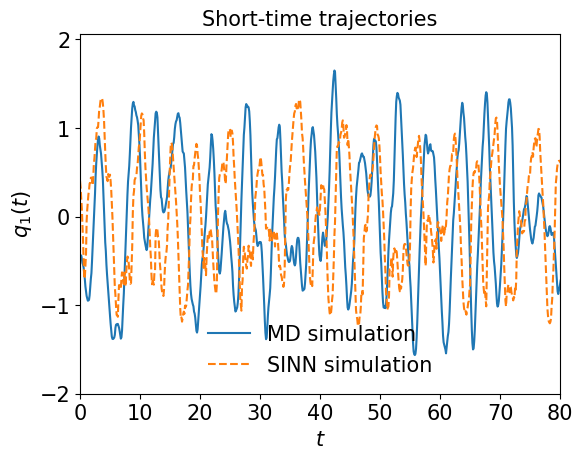

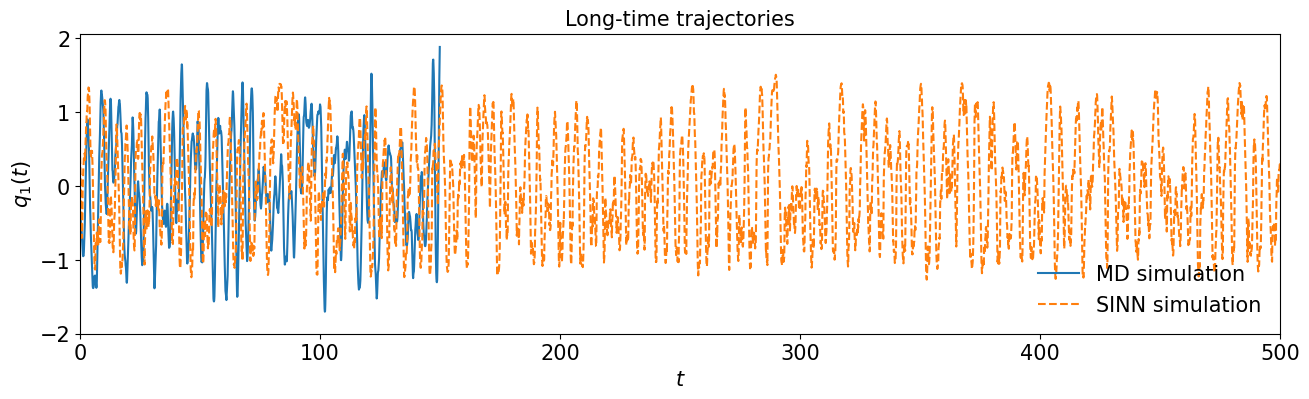

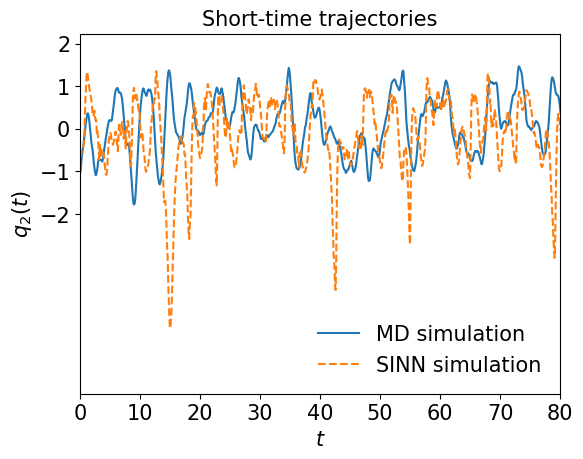

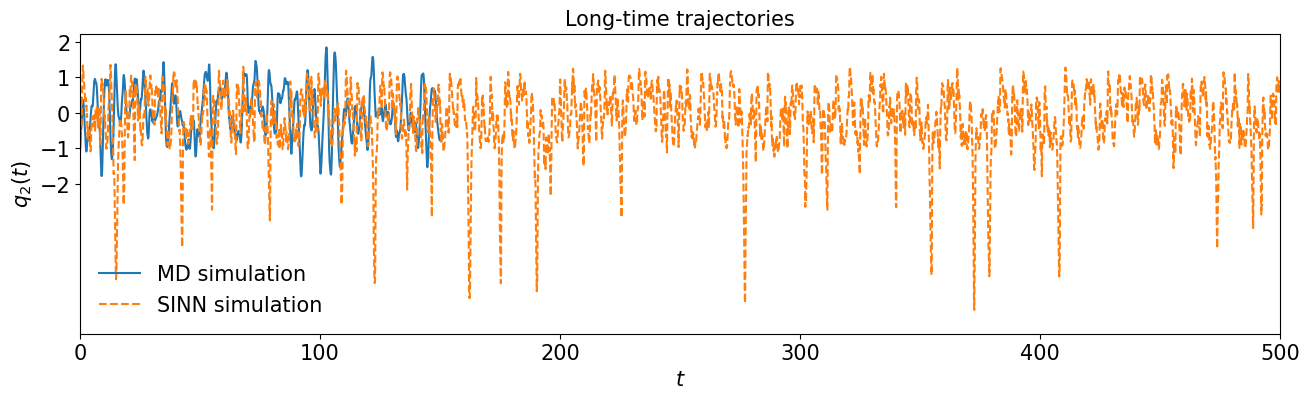

In [43]:
test5(q1_store, q2_store, net5)

# 2. 2 inputs

In [44]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [45]:
def SINN_training(net, optimizer, c1, c2, c3):
    # Training SINN
    T_error=[]
    V_error=[]
    T_ccf=[]
    V_ccf=[]
    T_pdf=[]
    V_pdf=[]
    T_acf=[]
    V_acf=[]
    Step=[]
    for step in range(20000):
        optimizer.zero_grad()
        ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
        input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
        prediction, _ = net(input)
        prediction = prediction[-LAGS:,:,:]
        loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
        loss.backward()
        optimizer.step()
        if step % 50 == 0: 
            with torch.no_grad():
                pred_val, _ = net(val_set)
                pred_val = pred_val[-LAGS:,:,:]
                loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
                print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
                T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
                V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
                T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                T_error.append(loss.detach().cpu().numpy())
                V_error.append(loss_val.detach().cpu().numpy())
                Step.append(step)
        if loss<=0.002 and loss_val<=0.0025:
                break
    print('Training finished')
    return Step, T_error, V_error, T_ccf, V_ccf, T_pdf, V_pdf, T_acf, V_acf

In [46]:
### Defining SINN model
net10 = SINN(2, 10, 2, 2).to(device)
optimizer10 = optim.Adam(net10.parameters(), lr=1e-3)

In [47]:
%%time
start = time.time()
Step10, T_error10, V_error10, T_ccf10, V_ccf10, T_pdf10, V_pdf10, T_acf10, V_acf10 = SINN_training(net10, optimizer10, c1, c2, c3)
end = time.time()

[0]-th step loss: 0.433, 0.412
[50]-th step loss: 0.306, 0.306
[100]-th step loss: 0.291, 0.290
[150]-th step loss: 0.284, 0.284
[200]-th step loss: 0.281, 0.281
[250]-th step loss: 0.239, 0.237
[300]-th step loss: 0.116, 0.111
[350]-th step loss: 0.009, 0.009
[400]-th step loss: 0.006, 0.005
[450]-th step loss: 0.005, 0.004
[500]-th step loss: 0.004, 0.004
[550]-th step loss: 0.003, 0.003
[600]-th step loss: 0.003, 0.003
[650]-th step loss: 0.003, 0.003
[700]-th step loss: 0.003, 0.003
[750]-th step loss: 0.003, 0.003
[800]-th step loss: 0.003, 0.003
[850]-th step loss: 0.003, 0.003
[900]-th step loss: 0.003, 0.003
[950]-th step loss: 0.003, 0.003
[1000]-th step loss: 0.002, 0.003
[1050]-th step loss: 0.003, 0.003
[1100]-th step loss: 0.003, 0.003
[1150]-th step loss: 0.003, 0.003
[1200]-th step loss: 0.002, 0.003
[1250]-th step loss: 0.002, 0.003
[1300]-th step loss: 0.003, 0.003
[1350]-th step loss: 0.002, 0.003
[1400]-th step loss: 0.002, 0.003
[1450]-th step loss: 0.002, 0.003
[15

In [48]:
time10=exec_time(start,end)

Execution Time: 00:02:17


In [49]:
### Defining SINN model
net9 = SINN(2, 9, 2, 2).to(device)
optimizer9 = optim.Adam(net9.parameters(), lr=1e-3)

In [50]:
%%time
start = time.time()
Step9, T_error9, V_error9, T_ccf9, V_ccf9, T_pdf9, V_pdf9, T_acf9, V_acf9 = SINN_training(net9, optimizer9, c1, c2, c3)
end = time.time()

[0]-th step loss: 0.370, 0.366
[50]-th step loss: 0.294, 0.292
[100]-th step loss: 0.211, 0.211
[150]-th step loss: 0.168, 0.168
[200]-th step loss: 0.122, 0.118
[250]-th step loss: 0.021, 0.020
[300]-th step loss: 0.008, 0.008
[350]-th step loss: 0.006, 0.005
[400]-th step loss: 0.014, 0.014
[450]-th step loss: 0.004, 0.004
[500]-th step loss: 0.004, 0.004
[550]-th step loss: 0.003, 0.003
[600]-th step loss: 0.004, 0.003
[650]-th step loss: 0.003, 0.003
[700]-th step loss: 0.003, 0.003
[750]-th step loss: 0.003, 0.003
[800]-th step loss: 0.003, 0.002
[850]-th step loss: 0.003, 0.002
[900]-th step loss: 0.003, 0.003
[950]-th step loss: 0.003, 0.003
[1000]-th step loss: 0.003, 0.003
[1050]-th step loss: 0.003, 0.002
[1100]-th step loss: 0.003, 0.003
[1150]-th step loss: 0.003, 0.002
Training finished
CPU times: user 1min 42s, sys: 1.76 s, total: 1min 44s
Wall time: 1min 44s


In [51]:
time9=exec_time(start,end)

Execution Time: 00:01:45


In [52]:
### Defining SINN model
net8 = SINN(2, 8, 2, 2).to(device)
optimizer8 = optim.Adam(net8.parameters(), lr=1e-3)

In [53]:
%%time
start = time.time()
Step8, T_error8, V_error8, T_ccf8, V_ccf8, T_pdf8, V_pdf8, T_acf8, V_acf8 = SINN_training(net8, optimizer8, c1, c2, c3)
end = time.time()

[0]-th step loss: 0.468, 0.453
[50]-th step loss: 0.310, 0.309
[100]-th step loss: 0.290, 0.290
[150]-th step loss: 0.275, 0.273
[200]-th step loss: 0.097, 0.092
[250]-th step loss: 0.032, 0.032
[300]-th step loss: 0.013, 0.012
[350]-th step loss: 0.009, 0.008
[400]-th step loss: 0.007, 0.006
[450]-th step loss: 0.006, 0.005
[500]-th step loss: 0.005, 0.004
[550]-th step loss: 0.004, 0.004
[600]-th step loss: 0.003, 0.003
[650]-th step loss: 0.004, 0.003
[700]-th step loss: 0.003, 0.003
[750]-th step loss: 0.003, 0.003
[800]-th step loss: 0.003, 0.003
[850]-th step loss: 0.003, 0.003
[900]-th step loss: 0.004, 0.004
[950]-th step loss: 0.003, 0.003
[1000]-th step loss: 0.003, 0.002
[1050]-th step loss: 0.003, 0.003
[1100]-th step loss: 0.003, 0.003
[1150]-th step loss: 0.002, 0.003
[1200]-th step loss: 0.003, 0.003
[1250]-th step loss: 0.003, 0.003
[1300]-th step loss: 0.003, 0.003
[1350]-th step loss: 0.003, 0.003
[1400]-th step loss: 0.003, 0.003
[1450]-th step loss: 0.003, 0.003
[15

In [54]:
time8=exec_time(start,end)

Execution Time: 00:01:50


In [104]:
### Defining SINN model
net7 = SINN(2, 7, 2, 2).to(device)
optimizer7 = optim.Adam(net7.parameters(), lr=1e-3)

In [105]:
%%time
start = time.time()
Step7, T_error7, V_error7, T_ccf7, V_ccf7, T_pdf7, V_pdf7, T_acf7, V_acf7 = SINN_training(net7, optimizer7, c1, c2, c3)
end = time.time()

[0]-th step loss: 0.385, 0.382
[50]-th step loss: 0.299, 0.297
[100]-th step loss: 0.287, 0.286
[150]-th step loss: 0.257, 0.254
[200]-th step loss: 0.090, 0.088
[250]-th step loss: 0.044, 0.045
[300]-th step loss: 0.027, 0.025
[350]-th step loss: 0.012, 0.012
[400]-th step loss: 0.007, 0.007
[450]-th step loss: 0.006, 0.006
[500]-th step loss: 0.005, 0.005
[550]-th step loss: 0.004, 0.004
[600]-th step loss: 0.004, 0.004
[650]-th step loss: 0.005, 0.004
[700]-th step loss: 0.004, 0.004
[750]-th step loss: 0.004, 0.004
[800]-th step loss: 0.004, 0.004
[850]-th step loss: 0.004, 0.003
[900]-th step loss: 0.004, 0.003
[950]-th step loss: 0.004, 0.003
[1000]-th step loss: 0.003, 0.003
[1050]-th step loss: 0.004, 0.004
[1100]-th step loss: 0.004, 0.004
[1150]-th step loss: 0.003, 0.003
[1200]-th step loss: 0.003, 0.003
[1250]-th step loss: 0.003, 0.003
[1300]-th step loss: 0.006, 0.004
[1350]-th step loss: 0.003, 0.003
[1400]-th step loss: 0.004, 0.003
[1450]-th step loss: 0.004, 0.003
[15

In [106]:
time7=exec_time(start,end)

Execution Time: 00:03:11


In [107]:
### Defining SINN model
net6 = SINN(2, 6, 2, 2).to(device)
optimizer6 = optim.Adam(net6.parameters(), lr=1e-3)

In [108]:
%%time
start = time.time()
Step6, T_error6, V_error6, T_ccf6, V_ccf6, T_pdf6, V_pdf6, T_acf6, V_acf6 = SINN_training(net6, optimizer6, c1, c2, c3)
end = time.time()

[0]-th step loss: 0.398, 0.398
[50]-th step loss: 0.322, 0.320
[100]-th step loss: 0.281, 0.279
[150]-th step loss: 0.099, 0.096
[200]-th step loss: 0.036, 0.036
[250]-th step loss: 0.022, 0.021
[300]-th step loss: 0.015, 0.015
[350]-th step loss: 0.008, 0.008
[400]-th step loss: 0.005, 0.006
[450]-th step loss: 0.005, 0.005
[500]-th step loss: 0.005, 0.005
[550]-th step loss: 0.005, 0.004
[600]-th step loss: 0.004, 0.004
[650]-th step loss: 0.004, 0.004
[700]-th step loss: 0.003, 0.003
[750]-th step loss: 0.004, 0.003
[800]-th step loss: 0.004, 0.003
[850]-th step loss: 0.003, 0.003
[900]-th step loss: 0.004, 0.003
[950]-th step loss: 0.003, 0.003
[1000]-th step loss: 0.003, 0.003
[1050]-th step loss: 0.003, 0.003
[1100]-th step loss: 0.004, 0.003
[1150]-th step loss: 0.003, 0.003
[1200]-th step loss: 0.003, 0.003
[1250]-th step loss: 0.003, 0.003
[1300]-th step loss: 0.003, 0.003
[1350]-th step loss: 0.003, 0.003
[1400]-th step loss: 0.003, 0.003
[1450]-th step loss: 0.002, 0.003
[15

In [109]:
time6=exec_time(start,end)

Execution Time: 00:01:48


In [200]:
### Defining SINN model
net5 = SINN(2, 5, 2, 2).to(device)
optimizer5 = optim.Adam(net5.parameters(), lr=1e-3)

In [201]:
%%time
start = time.time()
Step5, T_error5, V_error5, T_ccf5, V_ccf5, T_pdf5, V_pdf5, T_acf5, V_acf5 = SINN_training(net5, optimizer5, c1, c2, c3)
end = time.time()

[0]-th step loss: 0.392, 0.384
[50]-th step loss: 0.310, 0.310
[100]-th step loss: 0.292, 0.292
[150]-th step loss: 0.288, 0.287
[200]-th step loss: 0.284, 0.283
[250]-th step loss: 0.276, 0.275
[300]-th step loss: 0.201, 0.199
[350]-th step loss: 0.172, 0.171
[400]-th step loss: 0.162, 0.164
[450]-th step loss: 0.159, 0.161
[500]-th step loss: 0.158, 0.158
[550]-th step loss: 0.155, 0.154
[600]-th step loss: 0.145, 0.145
[650]-th step loss: 0.065, 0.063
[700]-th step loss: 0.028, 0.026
[750]-th step loss: 0.020, 0.020
[800]-th step loss: 0.016, 0.016
[850]-th step loss: 0.014, 0.014
[900]-th step loss: 0.011, 0.011
[950]-th step loss: 0.010, 0.010
[1000]-th step loss: 0.009, 0.009
[1050]-th step loss: 0.008, 0.008
[1100]-th step loss: 0.007, 0.007
[1150]-th step loss: 0.007, 0.006
[1200]-th step loss: 0.006, 0.006
[1250]-th step loss: 0.006, 0.005
[1300]-th step loss: 0.005, 0.005
[1350]-th step loss: 0.005, 0.005
[1400]-th step loss: 0.004, 0.004
[1450]-th step loss: 0.005, 0.004
[15

In [202]:
time5=exec_time(start,end)

Execution Time: 00:02:28


In [203]:
### Defining SINN model
net4 = SINN(2, 4, 2, 2).to(device)
optimizer4 = optim.Adam(net4.parameters(), lr=1e-3)

In [ ]:
%%time
start = time.time()
Step4, T_error4, V_error4, T_ccf4, V_ccf4, T_pdf4, V_pdf4, T_acf4, V_acf4 = SINN_training(net4, optimizer4, c1, c2, c3)
end = time.time()

[0]-th step loss: 0.346, 0.345
[50]-th step loss: 0.286, 0.284
[100]-th step loss: 0.187, 0.185
[150]-th step loss: 0.095, 0.092
[200]-th step loss: 0.062, 0.061
[250]-th step loss: 0.048, 0.045
[300]-th step loss: 0.035, 0.034
[350]-th step loss: 0.025, 0.025
[400]-th step loss: 0.023, 0.021
[450]-th step loss: 0.020, 0.019
[500]-th step loss: 0.019, 0.018
[550]-th step loss: 0.017, 0.017
[600]-th step loss: 0.017, 0.015
[650]-th step loss: 0.015, 0.014
[700]-th step loss: 0.013, 0.012
[750]-th step loss: 0.016, 0.020
[800]-th step loss: 0.012, 0.012
[850]-th step loss: 0.010, 0.009
[900]-th step loss: 0.009, 0.009
[950]-th step loss: 0.009, 0.009
[1000]-th step loss: 0.008, 0.007
[1050]-th step loss: 0.009, 0.009
[1100]-th step loss: 0.007, 0.006
[1150]-th step loss: 0.006, 0.007
[1200]-th step loss: 0.006, 0.006
[1250]-th step loss: 0.006, 0.006
[1300]-th step loss: 0.006, 0.005
[1350]-th step loss: 0.005, 0.005
[1400]-th step loss: 0.005, 0.005
[1450]-th step loss: 0.006, 0.006
[15

[12050]-th step loss: 0.048, 0.050
[12100]-th step loss: 0.050, 0.049
[12150]-th step loss: 0.045, 0.047
[12200]-th step loss: 0.044, 0.046
[12250]-th step loss: 0.045, 0.045
[12300]-th step loss: 0.044, 0.044
[12350]-th step loss: 0.041, 0.043
[12400]-th step loss: 0.044, 0.042
[12450]-th step loss: 0.040, 0.042
[12500]-th step loss: 0.040, 0.041
[12550]-th step loss: 0.040, 0.040
[12600]-th step loss: 0.038, 0.039
[12650]-th step loss: 0.036, 0.038
[12700]-th step loss: 0.037, 0.038
[12750]-th step loss: 0.036, 0.037
[12800]-th step loss: 0.037, 0.036
[12850]-th step loss: 0.036, 0.036
[12900]-th step loss: 0.035, 0.035
[12950]-th step loss: 0.035, 0.035
[13000]-th step loss: 0.033, 0.034
[13050]-th step loss: 0.034, 0.033
[13100]-th step loss: 0.032, 0.033
[13150]-th step loss: 0.032, 0.032
[13200]-th step loss: 0.032, 0.032
[13250]-th step loss: 0.031, 0.031
[13300]-th step loss: 0.030, 0.031
[13350]-th step loss: 0.029, 0.030
[13400]-th step loss: 0.028, 0.030
[13450]-th step loss

In [ ]:
time4=exec_time(start,end)

In [ ]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step10, T_error10,'r',label='Training error hidden size = 10, exec time: %s'%time10)
plt.loglog(Step10, V_error10,'r--')
plt.loglog(Step9, T_error9,'b',label='Training error hidden size = 9, exec time: %s'%time9)
plt.loglog(Step9, V_error9,'b--')
plt.loglog(Step8, T_error8,'g',label='Training error hidden size = 8, exec time: %s'%time8)
plt.loglog(Step8, V_error8,'g--')
plt.loglog(Step7, T_error7,'k',label='Training error hidden size = 7, exec time: %s'%time7)
plt.loglog(Step7, V_error7,'k--')
plt.loglog(Step6, T_error6,'c',label='Training error hidden size = 6, exec time: %s'%time6)
plt.loglog(Step6, V_error6,'c--')
plt.loglog(Step5, T_error5,'m',label='Training error hidden size = 5, exec time: %s'%time5)
plt.loglog(Step5, V_error5,'m--')
plt.loglog(Step4, T_error4,label='Training error hidden size = 4, exec time: %s'%time4)
plt.loglog(Step4, V_error4,'--')
# plt.loglog(Step3, T_error3,label='Training error hidden size = 3, exec time: %s'%time3)
# plt.loglog(Step3, V_error3,'--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [ ]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("CCF plot",fontsize=15) 
plt.loglog(Step10, T_ccf10,'r',label='Training error hidden size = 10, exec time: %s'%time10)
plt.loglog(Step10, V_ccf10,'r--')
plt.loglog(Step9, T_ccf9,'b',label='Training error hidden size = 9, exec time: %s'%time9)
plt.loglog(Step9, V_ccf9,'b--')
plt.loglog(Step8, T_ccf8,'g',label='Training error hidden size = 8, exec time: %s'%time8)
plt.loglog(Step8, V_ccf8,'g--')
plt.loglog(Step7, T_ccf7,'k',label='Training error hidden size = 7, exec time: %s'%time7)
plt.loglog(Step7, V_ccf7,'k--')
plt.loglog(Step6, T_ccf6,'c',label='Training error hidden size = 6, exec time: %s'%time6)
plt.loglog(Step6, V_ccf6,'c--')
plt.loglog(Step5, T_ccf5,'m',label='Training error hidden size = 5, exec time: %s'%time5)
plt.loglog(Step5, V_ccf5,'m--')
plt.loglog(Step4, T_ccf4,label='Training error hidden size = 4, exec time: %s'%time4)
plt.loglog(Step4, V_ccf4,'--')
# plt.loglog(Step3, T_ccf3,label='Training error hidden size = 3, exec time: %s'%time3)
# plt.loglog(Step3, V_ccf3,'--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [ ]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("PDF plot",fontsize=15) 
plt.loglog(Step10, T_pdf10,'r',label='Training error hidden size = 10, exec time: %s'%time10)
plt.loglog(Step10, V_pdf10,'r--')
plt.loglog(Step9, T_pdf9,'b',label='Training error hidden size = 9, exec time: %s'%time9)
plt.loglog(Step9, V_pdf9,'b--')
plt.loglog(Step8, T_pdf8,'g',label='Training error hidden size = 8, exec time: %s'%time8)
plt.loglog(Step8, V_pdf8,'g--')
plt.loglog(Step7, T_pdf7,'k',label='Training error hidden size = 7, exec time: %s'%time7)
plt.loglog(Step7, V_pdf7,'k--')
plt.loglog(Step6, T_pdf6,'c',label='Training error hidden size = 6, exec time: %s'%time6)
plt.loglog(Step6, V_pdf6,'c--')
plt.loglog(Step5, T_pdf5,'m',label='Training error hidden size = 5, exec time: %s'%time5)
plt.loglog(Step5, V_pdf5,'m--')
plt.loglog(Step4, T_pdf4,label='Training error hidden size = 4, exec time: %s'%time4)
plt.loglog(Step4, V_pdf4,'--')
# plt.loglog(Step3, T_pdf3,label='Training error hidden size = 3, exec time: %s'%time3)
# plt.loglog(Step3, V_pdf3,'--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [ ]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("ACF plot",fontsize=15) 
plt.loglog(Step10, T_acf10,'r',label='Training error hidden size = 10, exec time: %s'%time10)
plt.loglog(Step10, V_acf10,'r--')
plt.loglog(Step9, T_acf9,'b',label='Training error hidden size = 9, exec time: %s'%time9)
plt.loglog(Step9, V_acf9,'b--')
plt.loglog(Step8, T_acf8,'g',label='Training error hidden size = 8, exec time: %s'%time8)
plt.loglog(Step8, V_acf8,'g--')
plt.loglog(Step7, T_acf7,'k',label='Training error hidden size = 7, exec time: %s'%time7)
plt.loglog(Step7, V_acf7,'k--')
plt.loglog(Step6, T_acf6,'c',label='Training error hidden size = 6, exec time: %s'%time6)
plt.loglog(Step6, V_acf6,'c--')
plt.loglog(Step5, T_acf5,'m',label='Training error hidden size = 5, exec time: %s'%time5)
plt.loglog(Step5, V_acf5,'m--')
plt.loglog(Step4, T_acf4,label='Training error hidden size = 4, exec time: %s'%time4)
plt.loglog(Step4, V_acf4,'--')
# plt.loglog(Step3, T_acf3,label='Training error hidden size = 3, exec time: %s'%time3)
# plt.loglog(Step3, V_acf3,'--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [ ]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.loglog(Step5, T_error5,'k',label='Training error hidden size = 5, exec time: %s'%time5)
plt.loglog(Step5, V_error5,'k--')
plt.loglog(Step5, T_ccf5,'r',label='ccf error hidden size = 5')
plt.loglog(Step5, V_ccf5,'r--')
plt.loglog(Step5, T_pdf5,'b',label='pdf error hidden size = 5')
plt.loglog(Step5, V_pdf5,'b--')
plt.loglog(Step5, T_acf5,'g',label='acf error hidden size = 5')
plt.loglog(Step5, V_acf5,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [ ]:
T_ccf5_new = [i * c1 for i in T_ccf5]
T_pdf5_new = [i * c2 for i in T_pdf5]
T_acf5_new = [i * c3 for i in T_acf5]
T_err5_new = [x + y + z for x, y, z in zip(T_ccf5_new, T_pdf5_new, T_acf5_new)]
plt.loglog(Step5, T_ccf5_new,'r',label='ccf error hidden size = 5')
plt.loglog(Step5, T_pdf5_new,'b',label='pdf error hidden size = 5')
plt.loglog(Step5, T_acf5_new,'g',label='acf error hidden size = 5')
plt.loglog(Step5, T_err5_new,'k--',label='sum error hidden size = 5')
plt.loglog(Step5, T_error5,'k',label='Training error hidden size = 5, exec time: %s'%time5)

In [ ]:
test1(Traj, T, net10)

In [ ]:
test1(Traj, T, net9)

In [ ]:
test1(Traj, T, net8)

In [ ]:
test1(Traj, T, net7)

In [ ]:
test1(Traj, T, net6)

In [ ]:
test1(Traj, T, net5)

In [ ]:
test1(Traj, T, net4)

In [ ]:
test2(target, net10)

In [ ]:
test2(target, net9)

In [ ]:
test2(target, net8)

In [ ]:
test2(target, net7)

In [ ]:
test2(target, net6)

In [ ]:
test2(target, net5)

In [ ]:
test2(target, net4)

In [ ]:
test3(target, net10)

In [ ]:
test3(target, net9)

In [ ]:
test3(target, net8)

In [ ]:
test3(target, net7)

In [ ]:
test3(target, net6)

In [ ]:
test3(target, net5)

In [ ]:
test3(target, net4)

In [ ]:
test4(target, net10)

In [ ]:
test4(target, net9)

In [ ]:
test4(target, net8)

In [ ]:
test4(target, net7)

In [ ]:
test4(target, net6)

In [ ]:
test4(target, net5)

In [ ]:
test4(target, net4)

In [ ]:
test5(q1_store, q2_store, net10)

In [ ]:
test5(q1_store, q2_store, net9)

In [ ]:
test5(q1_store, q2_store, net8)

In [ ]:
test5(q1_store, q2_store, net7)

In [ ]:
test5(q1_store, q2_store, net6)

In [ ]:
test5(q1_store, q2_store, net5)

In [ ]:
test5(q1_store, q2_store, net4)

# END